In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from skimage import measure, color, io
import json

In [2]:
# found lots of image values > 0 and < 255.  Fix those
def my_threshold(x):
    return 255 if x > 250 else 0

my_threshold = np.vectorize(my_threshold)

def get_labels(mask_file_name):
    mask_image = Image.open(mask_file_name).convert('L')
    mask_array = np.reshape(np.asarray(mask_image),(mask_image.height,mask_image.width))
    total_pixels = mask_image.height * mask_image.width
    # get rid of any 255,254 noise
    #mask_array = np.clip(mask_array*100.0,0,255).astype('uint8')
    mask_array = my_threshold(mask_array)
    #print(mask_array.dtype,mask_array.shape,np.min(mask_array),np.max(mask_array))
    # label individual regions
    mask_labels, num_labels = measure.label(mask_array,return_num=True,background=0.0,connectivity=2)
    #print(mask_labels.shape,num_labels)
    return total_pixels, mask_labels, num_labels

def get_rects(total_pixels,mask_labels):
    # find rectangles and return as array of tuples (x0,y0,w,h)
    regions = []
    mask_props = measure.regionprops(mask_labels)
    ave_h = 0
    num_good_labels = 0
    for i in range(num_labels):
        if mask_props[i].area > total_pixels*0.005:
            (y0,x0,y1,x1) = mask_props[i].bbox
            h = (y1-y0)
            ave_h += h
            num_good_labels += 1
    ave_h /= num_good_labels
    ave_h2 = ave_h/2
    print("good_regions = %d"%(num_good_labels))
    for i in range(num_labels):
        if mask_props[i].area > total_pixels*0.005:
            (y0,x0,y1,x1) = mask_props[i].bbox
            yc,xc = mask_props[i].centroid
            h = (y1-y0)
            h2 = h/2
            # m = 0 FIXME to deal with rotations
            regions.append((x0,int(yc-ave_h2),(x1-x0),int(ave_h),0.0,int(yc)))
    if len(regions) == 0:
        print("No good regions found")
        return []
    if len(regions) == 1:
        print("Only one region.  Guessing at ave_dy")
        ave_dy = 3*ave_h
    else:
        ave_dy = 0
        for i in range(len(regions)-1):
            (x,y,w,h,m,b) = regions[i]
            (_,y1,_,_,_,b1) = regions[i+1]
            dy = y1 - y
            ave_dy += dy
        ave_dy /= len(regions)-1
    ave_dy2 = ave_dy/2
    out_h2 = int(ave_dy2 * 1.5) # a little more margin is good
    rects = []
    for i in range(len(regions)):
        (x,y,w,h,m,b) = regions[i]
        rects.append((x,y+h//2-out_h2,w,2*out_h2))
    return rects

def get_score_image(base_name):
    score_file_name = f'../setup/{base_name}.png'
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image

def save_score_training_images(base_name,output_path,rects,training_info):
    score_image = get_score_image(base_name)
    for i,(x,y,w,h) in enumerate(rects):
        name = 'strip_score_%s_%02d.png'%(base_name,i)
        #print("%s %d %d"%(name,x,y))
        training_info.append({"name": name, "x": x, "y": y, "width": w, "height": h})
        score_image.crop((x,y,x+w,y+h)).save(output_path+"/"+name) 

In [4]:
# do this once
#!mkdir data/train2

This uses the data/results/pred\_mask\_\*... files to create data/train2/ png files that are isolated 'strips' that exactly isolate a staff.  The json file also describes these strips in order to help train.

In [6]:
#base_name = 'gen_one'
training_info = []
for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
    print(f"base_name = {base_name}")
    total_pixels, mask_labels, num_labels = get_labels(f"data/results/pred_mask_{base_name}.png")
    rects = get_rects(total_pixels, mask_labels)
    save_score_training_images(base_name,'data/train2',rects,training_info)
print("saving json info file.")
with open(f"data/train2/strip_score_info.json", 'w') as outfile:
    json.dump(training_info, outfile, indent = 2)

base_name = chromatic
good_regions = 1
Only one region.  Guessing at ave_dy
base_name = chromatic_piano
good_regions = 2
base_name = gen_one
good_regions = 8
base_name = gen_two
good_regions = 12
base_name = twinkle
good_regions = 2
saving json info file.


In [5]:
# remains of earlier iterations...

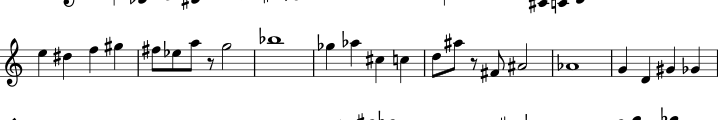

In [7]:
score_image = get_score_image('gen_two')
out_path = 'data/train'
(x,y,w,h) = rects[-1]
score_image.crop((x,y,x+w,y+h))#.save()

good_regions = 12


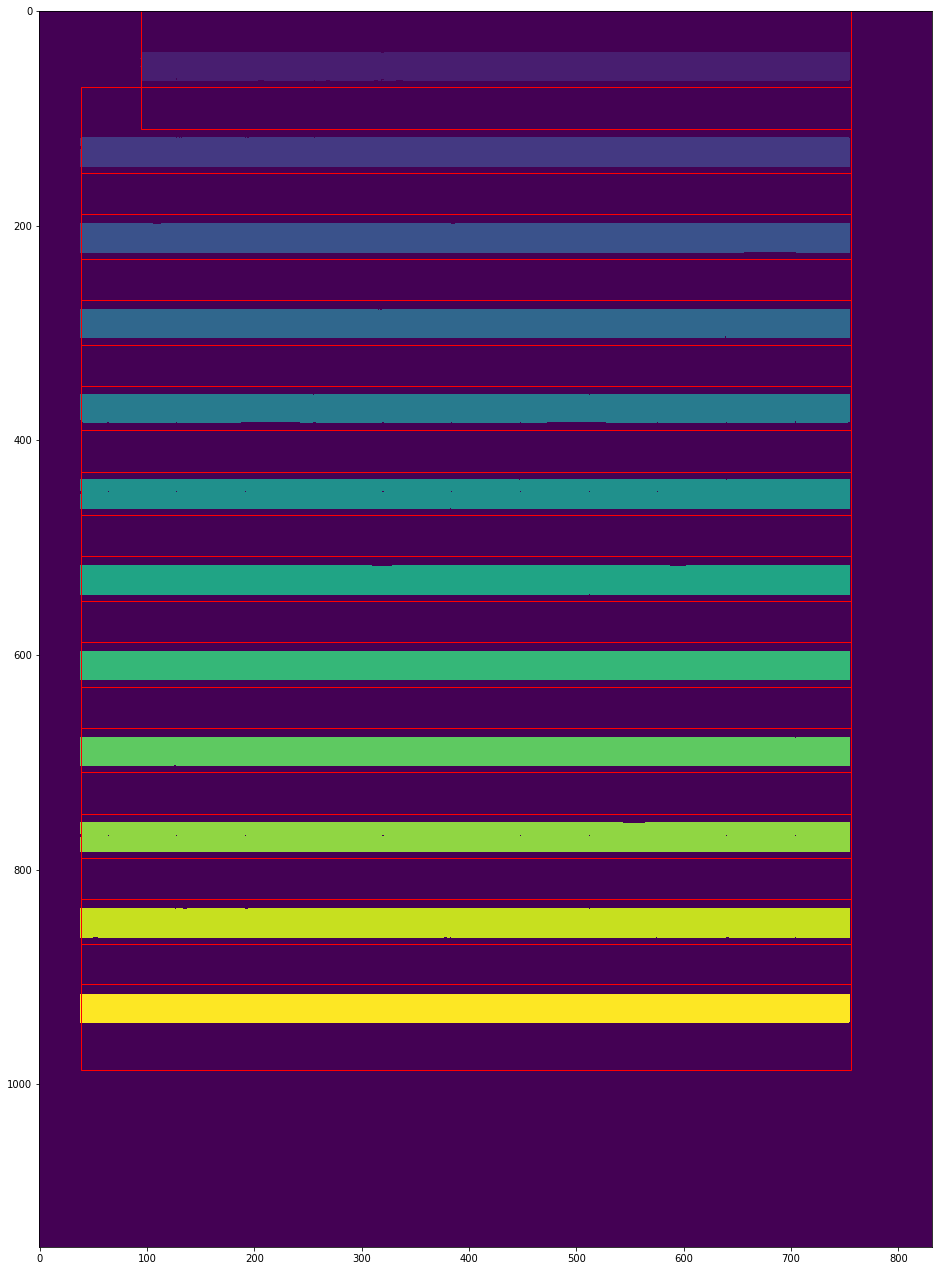

In [9]:
total_pixels, mask_labels, num_labels = get_labels(f"data/results/pred_mask_gen_two.png")
rects = get_rects(total_pixels, mask_labels)
#    
fig,ax = plt.subplots(1,figsize=(16,23))
ax.imshow(mask_labels)#,vmin=32,vmax=568) #cmap="Greys",
for (x,y,w,h) in rects:
    ax.add_patch(patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

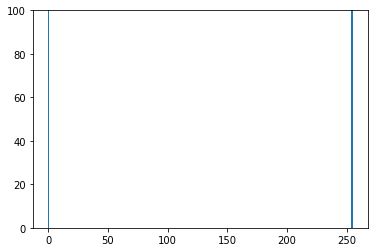

In [11]:
# playing with histograms & found had to zoom in to see spots using valuese > 0 and < 255.
# used this to create myclamp
mask_image = Image.open("data/results/pred_mask_gen_two.png").convert('L')
mask_array = np.reshape(np.asarray(mask_image),(mask_image.height*mask_image.width))
#mask_array = np.clip(mask_array*1.0,0,255).astype('uint8')
mask_array = my_threshold(mask_array)
plt.hist(mask_array,bins=256)# = mask_array*2
plt.ylim((0,100))
plt.show()

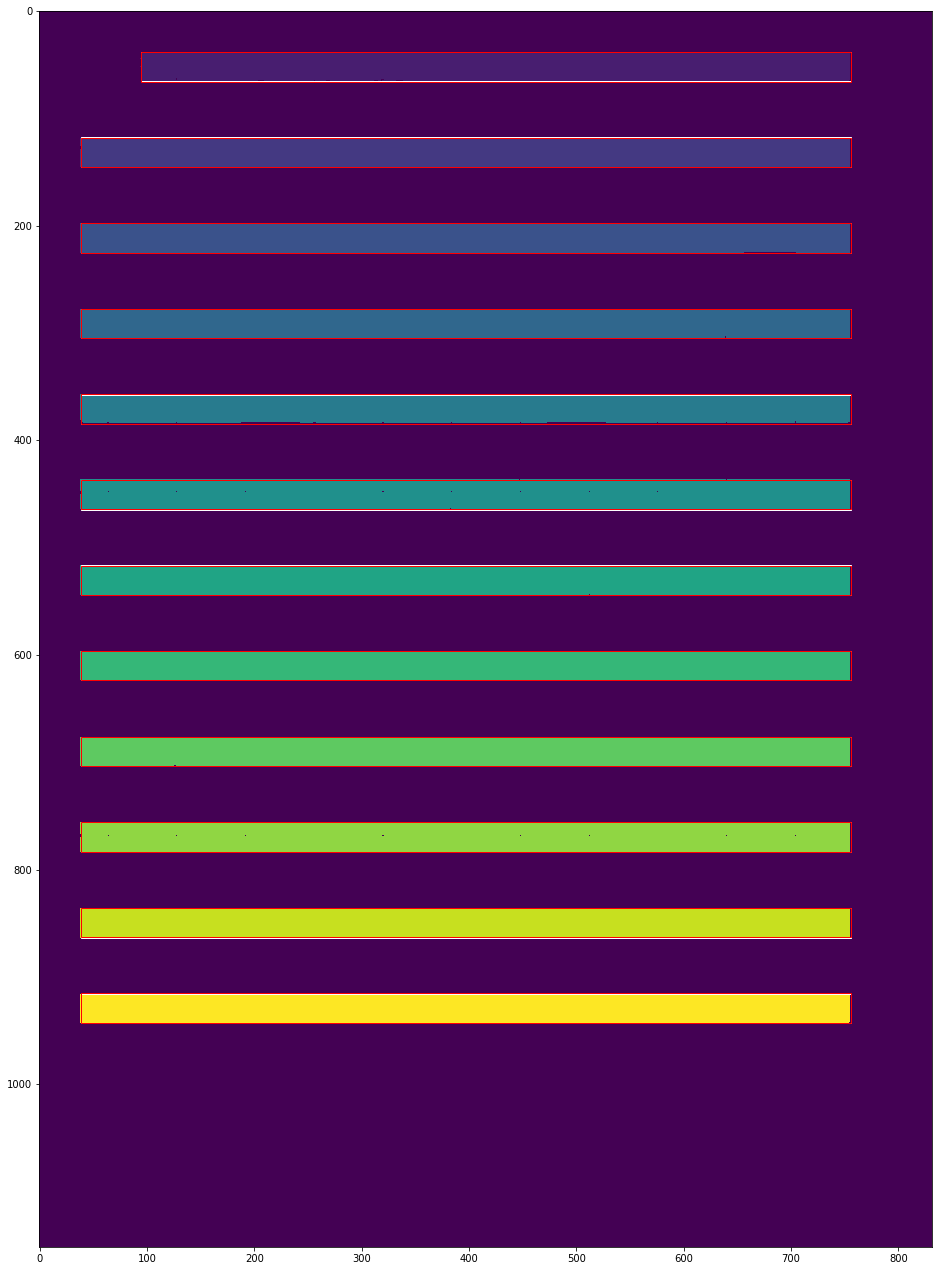

In [12]:
fig,ax = plt.subplots(1,figsize=(16,23))
ax.imshow(mask_labels)#,vmin=32,vmax=568) #cmap="Greys",
mask_props = measure.regionprops(mask_labels)
ave_h = 0
num_good_labels = 0
for i in range(num_labels):
    if mask_props[i].area > total_pixels*0.005:
        (y0,x0,y1,x1) = mask_props[i].bbox
        h = (y1-y0)
        ave_h += h
        num_good_labels += 1
ave_h /= num_good_labels
ave_h2 = ave_h/2
for i in range(num_labels):
    if mask_props[i].area > total_pixels*0.005:
        (y0,x0,y1,x1) = mask_props[i].bbox
        yc,xc = mask_props[i].centroid
        #m1,b1 = np.polyfit(mask_props[i].coords[:,0],mask_props[i].coords[:,1],1)
        #print(i,x0,y0,x1,y1,m1,b1,(y1+y0)/2)
        h = (y1-y0)
        h2 = h/2
        ax.add_patch(patches.Rectangle((x0,yc-h2),(x1-x0),h,linewidth=1,edgecolor='w',facecolor='none'))
        ax.add_patch(patches.Rectangle((x0,yc-ave_h2),(x1-x0),ave_h,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()
        